In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

 - With majority of picture we see or took by phone, there will be background color that affected the performance of the model.
 - Here's a simple cv grubcut method to remove picutre background in order to improve accuracy on certain pictures

In [ ]:
img_i = cv2.imread("C:/Users/Murphy/Documents/17.jpg")

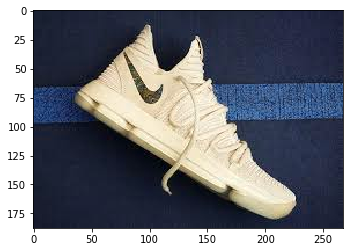

In [22]:
plt.imshow(img_i)

- Orignal Pictrue

In [23]:
img_i = cv2.imread("C:/Users/Murphy/Documents/17.jpg")
#img_i=data[0]

h,w=img_i.shape[:2]
mask = np.zeros(img_i.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (int(0.1*w),int(0.1*h),int(0.9*w),int(0.9*h))

cv2.grabCut(img_i,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_o = img_i*mask2[:,:,np.newaxis]

background = img_i-img_o
#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] =[255,255,255]
#Add the background and the image
final = background + img_o


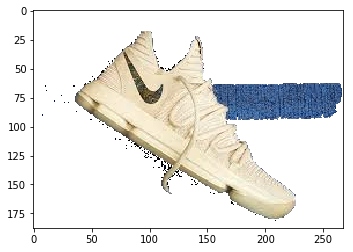

In [24]:
plt.imshow(final)

- After image processing

In [ ]:
#Code for simple flask-app (http://whatrth0se.herokuapp.com/)

import os
from flask import Flask, render_template, request
from flask import send_from_directory
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
import json
import cv2

app = Flask(__name__)

dir_path = os.path.dirname(os.path.realpath(__file__))
# UPLOAD_FOLDER = dir_path + '/uploads'
# STATIC_FOLDER = dir_path + '/static'
UPLOAD_FOLDER = 'uploads'
STATIC_FOLDER = 'static'

graph = tf.get_default_graph()
with graph.as_default():
    # load model at very first
    json_file = open(dir_path+'/'+STATIC_FOLDER + '/' 'fine_tune_64.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(dir_path+'/'+STATIC_FOLDER + '/' 'fine_tune_64.h5')


# call model to predict an image
def api(full_path,rmbg):
    
    data = image.load_img(full_path, target_size=(224, 224, 3))
    data = np.expand_dims(data, axis=0)
    if(rmbg=='Yes'):
        data = rmbg(data)
    data = data * 1.0 / 255

    with graph.as_default():
        predicted = model.predict(data)
        return predicted

def rmbg(data):
    img_i=data[0]
    h,w=img_i.shape[:2]
    mask = np.zeros(img_i.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (int(0.1*w),int(0.1*h),int(0.9*w),int(0.85*h))

    cv2.grabCut(img_i,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_o = img_i*mask2[:,:,np.newaxis]

    background = img_i-img_o
    #Change all pixels in the background that are not black to white
    background[np.where((background > [0,0,0]).all(axis = 2))] =[255,255,255]
    #Add the background and the image
    final = background + img_o
    return final


# home page
@app.route('/')
def home():
    return render_template('index.html')


# procesing uploaded file and predict it
@app.route('/upload', methods=['POST','GET'])
def upload_file():

    if request.method == 'GET':
        return render_template('index.html')
    else:
        file = request.files['image']
        full_name = os.path.join(UPLOAD_FOLDER, file.filename)
        file.save(full_name)

        with open(dir_path+'/'+'key.json', 'r') as fp:
            indices = json.load(fp)
        
        result = api(full_name)

        predicted_class = np.asscalar(np.argmax(result, axis=1))
        accuracy = round(result[0][predicted_class] * 100, 2)	

        label = indices[str(predicted_class)]

    return render_template('predict.html', image_file_name = file.filename, label = label, accuracy = accuracy)


@app.route('/uploads/<filename>')
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)

if __name__ == '__main__':
    app.debug = True
    port = int(os.environ.get('PORT', 5000))
    app.run(debug=True,host='127.0.0.1',port=port)
    app.debug = True